# Project 7 - Twitter Airline Sentiment Analysis

### Objective: 
Perform sentiment analysis of tweets directed at major airlines. The dataset is a list of tweets with manually generated positive/negative labels.

### Approach
1. Focus on sentiment, reasons for negative sentiment, and tweet text.

2. Clean data

3. EDA – frequency charts

4. Text vectorization for word clustering


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn import metrics

%matplotlib inline

# Load data

In [2]:
df = pd.read_csv('Tweets.csv')
raw = pd.read_csv('raw.csv')
y_actual = df['airline_sentiment']
df = df.drop(['negativereason_confidence',
              'airline_sentiment_confidence',
              'airline_sentiment_gold',
              'negativereason_gold',
              'tweet_coord',
              'tweet_location',
              'user_timezone',], 
             axis = 1)

IOError: File Tweets.csv does not exist

In [ ]:
df.head(3)

In [ ]:
airlines = ['@united','@americanair','@virginamerica',
            '@usairways','@southwestair','@delta','@jetblue']
df['text'] = df['text'].str.lower()

#Remove twitter tags
for a in airlines:
    df['text'] = df['text'].str.replace(a,'')

print len(df[df['text'].str.contains('jetblue')]['text'])

df.head()

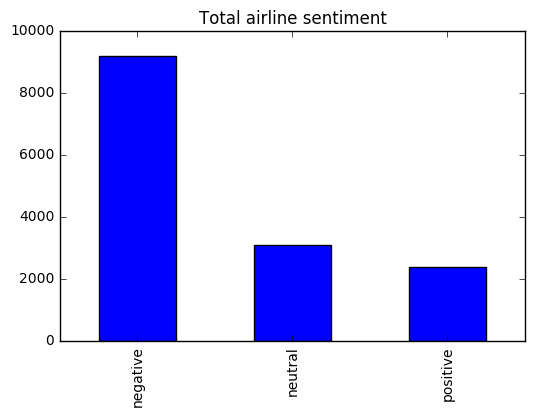

In [7]:
df['airline_sentiment'].value_counts().plot(kind='bar')
plt.title("Total airline sentiment")
plt.show()
# Many more negative tweets than positive

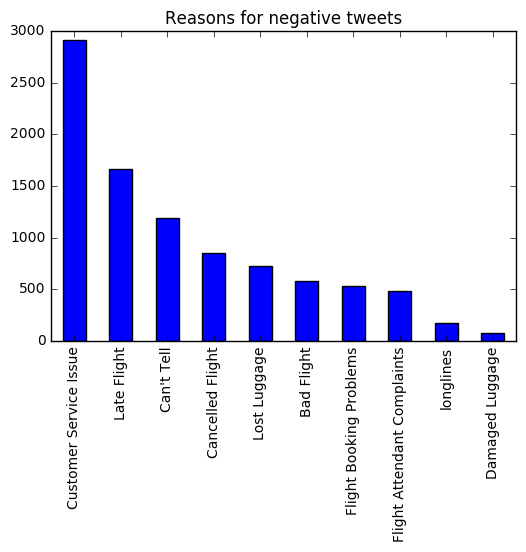

In [8]:
ndf = df['negativereason'].dropna()

ndf.value_counts().plot(kind='bar')
plt.title("Reasons for negative tweets")
plt.show()

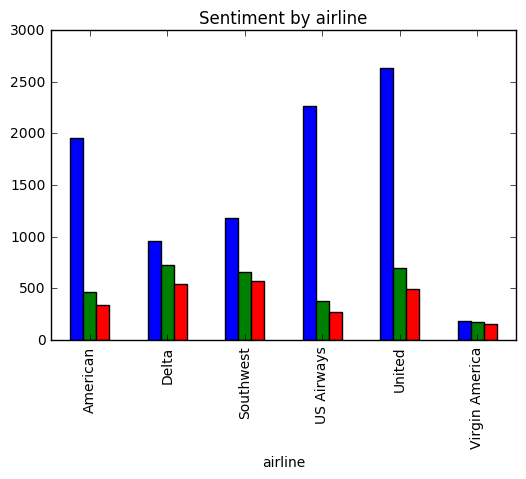

In [9]:
data = df.copy()
data['countval']=1
groupby_object=data[['airline','airline_sentiment','countval']].groupby(['airline','airline_sentiment']).aggregate(sum)
groupby_object.unstack(level=1).plot(kind='bar', legend = False)
plt.title('Sentiment by airline')
plt.show()

In [10]:
#POSITIVE TWEETS
positive_tweets = df[df['airline_sentiment'] == 'positive']['text']

v = TfidfVectorizer(stop_words='english', 
                        token_pattern='[A-Za-z]{4,50}', 
                        ngram_range=(1, 1),
                        max_features = 20,
                        min_df = 2,
                        max_df = .5,
                        )

p_vec = v.fit(positive_tweets)
positive_text = v.fit_transform(positive_tweets)

ndf = pd.DataFrame(positive_text.todense(), columns = p_vec.get_feature_names())
ndf

temp = []
for col in ndf.columns.values:
    temp.append(np.sum(ndf[col]))

pos_frequency = pd.DataFrame(temp, index = ndf.columns.values, columns = ['Frequency']).sort_values('Frequency', ascending = False)
p = ndf.columns.values
print "Positive word frequency table"
pos_frequency[:10]

Positive word frequency table


,Frequency
thanks,436.938092
thank,340.779830
flight,231.817229
http,165.733030
great,154.052625
just,128.987396
love,105.659453
service,93.924894
good,86.225641
awesome,76.027290


In [11]:
SVD = TruncatedSVD(n_components = 14, random_state=42)
SVD.fit_transform(positive_text)

SVD.explained_variance_ratio_.sum()
pos_words = pd.DataFrame(SVD.components_.T, index = p_vec.get_feature_names())
pos_words.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
airline,0.009090,0.012481,0.035865,0.031891,0.025857,0.049663,0.098264,-0.000571,0.000269,0.171006,0.417409,-0.052984,0.130235,-0.059699
amazing,0.014159,0.018739,0.032714,0.020591,0.013926,0.057610,0.069169,0.114869,0.010833,0.013923,0.064471,-0.031053,-0.017119,0.059876
awesome,0.032203,0.017967,0.040876,0.001137,0.026676,0.020507,0.058968,0.090385,0.004302,0.804236,-0.446031,-0.116383,0.026424,-0.329721
best,0.014949,0.022130,0.049139,0.022850,0.017814,0.102925,0.127683,0.160138,-0.007602,0.258357,0.725593,-0.170871,0.176313,-0.206602
crew,0.017298,0.011047,0.076957,0.004229,0.058446,0.003049,-0.014202,-0.010899,0.021779,0.080688,-0.044770,-0.031154,0.009801,-0.019622


In [12]:
# NEGATIVE TWEETS
negative_tweets = df[df['airline_sentiment'] == 'negative']['text']

n_vec = v.fit(negative_tweets)
negative_text = v.fit_transform(negative_tweets)

ndf = pd.DataFrame(negative_text.todense(), columns = n_vec.get_feature_names())
ndf

temp = []
for col in ndf.columns.values:
    temp.append(np.sum(ndf[col]))

neg_frequency = pd.DataFrame(temp, index = ndf.columns.values, columns = ['Frequency']).sort_values('Frequency', ascending = False)
neg_frequency.head()

,Frequency
flight,1505.926681
cancelled,500.679455
service,485.565256
just,456.799719
help,432.834791


In [13]:
SVD = TruncatedSVD(n_components = 14, random_state=42)
SVD.fit_transform(negative_text)

SVD.explained_variance_ratio_.sum()

neg_words = pd.DataFrame(SVD.components_.T, index = n_vec.get_feature_names())
#neg_words[0].sort_values(ascending = False)[:10]
neg_words.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cancelled,0.206052,0.053729,0.256403,0.537740,0.300424,0.348373,-0.182365,-0.080782,0.131856,-0.039451,-0.054484,0.050685,-0.024647,-0.019786
customer,0.040853,0.597209,-0.231947,0.023886,0.016927,0.017864,0.002515,-0.010386,-0.009554,0.006686,-0.040284,-0.030180,-0.026582,0.018302
delayed,0.102654,0.018021,0.060898,-0.067235,-0.123148,0.014226,-0.125425,0.054885,-0.090437,0.676549,0.474819,-0.259385,-0.045665,0.015138
flight,0.938985,-0.156367,-0.229876,-0.095150,-0.006622,-0.080802,0.069457,0.016728,-0.036104,-0.057552,-0.041218,-0.018984,-0.008199,-0.006331
flightled,0.104085,0.030010,0.154799,0.321142,0.169074,0.203668,-0.112183,-0.046553,0.073724,-0.028702,-0.041669,0.039886,-0.005831,-0.004350


In [47]:
# TRY SOMETHING NEW
# Even out the distribution of positive/negatives

df_pos = df[df['airline_sentiment']=='positive']
df_neg = df[df['airline_sentiment']=='negative']
df_neg = df_neg[df_neg.index % 3 == 0]
print len(df_neg)
print len(df_pos)
posneg_df = pd.concat([df_pos, df_neg], axis=0)

def weights(positives, negatives, df):
    # Return a list of tweet weight based on given positive and negative words
    
    weights = []
    for tweet in df['text']:
        temp = 0
        for word in positives:
            if word in tweet.decode('utf-8'):
                temp += 10
        for word in negatives:
            if word in tweet.decode('utf-8'):
                temp -= 10
        weights.append(temp)
    return weights

df['top_20_weights'] = weights(pos_frequency.index,neg_frequency.index, df)
posneg_df['top_20_weights'] = weights(pos_frequency.index, neg_frequency.index, posneg_df)

3069
2363


In [48]:
tfidf = TfidfVectorizer(stop_words='english', 
                        token_pattern='[a-zA-Z]{4,50}',
                        ngram_range=(1,1), 
                        min_df=2, 
                        max_df=0.5
                       )

n_vec = tfidf.fit(df_neg['text'])
X_neg = tfidf.fit_transform(df_neg['text'])
X_neg_vocab = tfidf.vocabulary_

p_vec = tfidf.fit(df_pos['text'])
X_pos = tfidf.fit_transform(df_pos['text'])
X_pos_vocab = tfidf.vocabulary_

df['all_weights'] = weights(X_pos_vocab, X_neg_vocab, df)
posneg_df['all_weights'] = weights(X_pos_vocab, X_neg_vocab, posneg_df)

In [49]:
vec = tfidf.fit(posneg_df['text'])
posneg_text = tfidf.fit_transform(posneg_df['text'])
posneg_vocab = tfidf.vocabulary_

In [50]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(550)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
posneg_lsa = lsa.fit_transform(posneg_text)

In [51]:
posneg_lsa = pd.DataFrame(posneg_lsa)

weights = posneg_df.loc[:,('all_weights','top_20_weights')]
weights_copy = weights.copy()
weights_copy.index = range(5432)

final_X = pd.concat([weights_copy, posneg_lsa], axis = 1)

In [52]:
ac = AgglomerativeClustering(n_clusters=2)
ac.fit(final_X)
labels = pd.DataFrame(ac.labels_)

km2 = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=30)
km2.fit(final_X)
labels2 = pd.DataFrame(km2.labels_)

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report, homogeneity_score, adjusted_rand_score

# posneg_lsa + weights 
le = LabelEncoder()
y = le.fit_transform(posneg_df['airline_sentiment'])

y_pred = np.choose(labels, [0,1])
y_pred
print classification_report(y, y_pred)
print confusion_matrix(y, y_pred)
print 'Homogeneity Score:', homogeneity_score(y, y_pred[0])
print 'Rand:', adjusted_rand_score(y, y_pred[0])


             precision    recall  f1-score   support

          0       0.94      0.71      0.81      3069
          1       0.72      0.94      0.81      2363

avg / total       0.84      0.81      0.81      5432

[[2193  876]
 [ 137 2226]]
Homogeneity Score: 0.363453010268
Rand: 0.392845551789


In [54]:
y_pred2 = np.choose(labels2, [1,0])
print classification_report(y, y_pred2)
print confusion_matrix(y, y_pred2)
print 'Homogeneity Score:', homogeneity_score(y, y_pred2[0])
print 'Rand:', adjusted_rand_score(y, y_pred2[0])

             precision    recall  f1-score   support

          0       0.94      0.69      0.79      3069
          1       0.70      0.94      0.80      2363

avg / total       0.84      0.80      0.80      5432

[[2109  960]
 [ 135 2228]]
Homogeneity Score: 0.33835132195
Rand: 0.355768558281


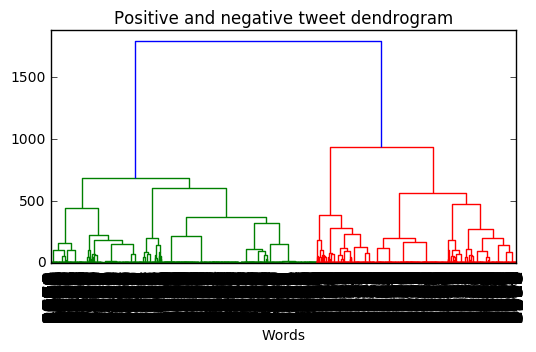

In [23]:
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

Z = linkage(final_X, 'ward')


plt.figure(figsize=(6,3))
plt.title('Positive and negative tweet dendrogram')
plt.xlabel('Words')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=15.,
)
plt.show()

# plot the two weught columns separated by hue


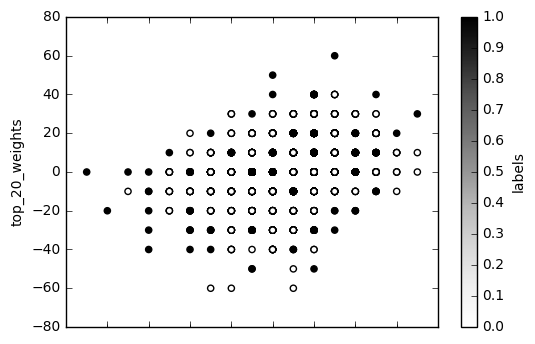

In [60]:
plot_df = pd.DataFrame()
plot_df['all_weights'] = posneg_df['all_weights']
plot_df['top_20_weights'] = posneg_df['top_20_weights']      
plot_df['labels'] = y_pred2
plot_df.plot(kind = 'scatter', x = 'all_weights', y ='top_20_weights', c = 'labels')


# x1 = posneg_df['all_weights']
# x2 = posneg_df['top_20_weights']

# plt.scatter(x = x1, y = x2)
# plt.show()


In [25]:
print("Top terms per cluster:")

order_centroids = km2.cluster_centers_.argsort()[:, ::-1]

terms = tfidf.get_feature_names()
for i in range(true_k):
    print "Cluster %d:" % i
    for ind in order_centroids[i, :10]:
        print ' %s' % terms[ind]


Top terms per cluster:


NameError: name 'true_k' is not defined

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


In [118]:
from sklearn.metrics import f1_score

# fit the kmeans with given features and return labels
def km_fitter(features):
    km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=30)
    km.fit(features)
    labels = pd.DataFrame(km.labels_)
    return labels

# fit the agglomerative clustering with given features and return labels
def ac_fitter(features):
    ac = AgglomerativeClustering(n_clusters=2)
    ac.fit(features)
    labels = pd.DataFrame(ac.labels_)
    return labels

# print classification report, confusion matrix, and return the predictions
def printer(labels):
    le = LabelEncoder()
    y = le.fit_transform(posneg_df['airline_sentiment'])
    
    
    labels2 = labels.copy()
    # get f1 score for one set of cnf matrix
    y_pred1 = np.choose(labels, [1,0])
    a = classification_report(y, y_pred1).split('total')[1].split('      ')[3]
    # get f1 score for other set
    y_pred2 = np.choose(labels2, [0,1])
    b = classification_report(y, y_pred2).split('total')[1].split('      ')[3]
    
    # Use the BEST cnf matrix for evaluation.
    if a >= b:
        y_pred = y_pred1
    else:
        y_pred = y_pred2
        
    print classification_report(y, y_pred)
    print confusion_matrix(y, y_pred)
    print 'Homogeneity Score:', homogeneity_score(y, y_pred[0])
    print 'Rand:', adjusted_rand_score(y, y_pred[0])
    return y_pred 

In [131]:
# Just posneg_lsa
print "Positive and negative terms with Latent Semantic Analysis"
print "<================================================================>"
km_labels = km_fitter(posneg_lsa)
ac_labels = ac_fitter(posneg_lsa)
print "Agglomerative Clustering"
ac_pred = printer(ac_labels)
print "<================================================================>"
print "KMeans Clustering"
km_pred = printer(km_labels)


Positive and negative terms with Latent Semantic Analysis
<================================================================>
Agglomerative Clustering
             precision    recall  f1-score   support

          0       0.58      1.00      0.73      3069
          1       1.00      0.04      0.08      2363

avg / total       0.76      0.58      0.45      5432

[[3069    0]
 [2262  101]]
Homogeneity Score: 0.0229392782598
Rand: 0.0124644450766
<================================================================>
KMeans Clustering
             precision    recall  f1-score   support

          0       0.60      1.00      0.75      3069
          1       0.99      0.12      0.21      2363

avg / total       0.77      0.62      0.51      5432

[[3065    4]
 [2083  280]]
Homogeneity Score: 0.0602442147268
Rand: 0.0406054180307


In [132]:
# Just the weights
print "Positive and negative terms with Latent Semantic Analysis"
print "<================================================================>"
km_labels = km_fitter(weights_copy)
ac_labels = ac_fitter(weights_copy)
print "Agglomerative Clustering"
ac_pred = printer(ac_labels)
print "<================================================================>"
print "KMeans Clustering"
km_pred = printer(km_labels)


Positive and negative terms with Latent Semantic Analysis
<================================================================>
Agglomerative Clustering
             precision    recall  f1-score   support

          0       0.96      0.52      0.68      3069
          1       0.61      0.97      0.75      2363

avg / total       0.81      0.72      0.71      5432

[[1607 1462]
 [  66 2297]]
Homogeneity Score: 0.249815253903
Rand: 0.18918072116
<================================================================>
KMeans Clustering
             precision    recall  f1-score   support

          0       0.94      0.69      0.79      3069
          1       0.70      0.94      0.80      2363

avg / total       0.84      0.80      0.80      5432

[[2109  960]
 [ 135 2228]]
Homogeneity Score: 0.33835132195
Rand: 0.355768558281


In [64]:
svd = TruncatedSVD(550)
normalizer = Normalizer(copy=False)

weights = posneg_df.loc[:,('all_weights','top_20_weights')]
weights_copy = weights.copy()
weights_copy.index = range(5432)

posneg_svd = svd.fit_transform(posneg_text)

posneg_svd = pd.DataFrame(posneg_svd)

test = pd.concat([weights_copy, posneg_lsa], axis = 1)

final_X_normal = normalizer.fit_transform(test)

In [133]:
# Weights plus LSA normalized
print "Positive and negative terms with Latent Semantic Analysis"
print "<================================================================>"
km_labels = km_fitter(final_X_normal)
ac_labels = ac_fitter(final_X_normal)
print "Agglomerative Clustering"
ac_pred = printer(ac_labels)
print "<================================================================>"
print "KMeans Clustering"
km_pred = printer(km_labels)

Positive and negative terms with Latent Semantic Analysis
<================================================================>
Agglomerative Clustering
             precision    recall  f1-score   support

          0       0.91      0.83      0.87      3069
          1       0.80      0.89      0.85      2363

avg / total       0.86      0.86      0.86      5432

[[2556  513]
 [ 258 2105]]
Homogeneity Score: 0.419901207081
Rand: 0.512738584204
<================================================================>
KMeans Clustering
             precision    recall  f1-score   support

          0       0.87      0.86      0.86      3069
          1       0.82      0.83      0.83      2363

avg / total       0.85      0.85      0.85      5432

[[2635  434]
 [ 393 1970]]
Homogeneity Score: 0.38052498906
Rand: 0.483524129495


Positive and negative terms with Latent Semantic Analysis
<================================================================>
Agglomerative Clustering
             precision    recall  f1-score   support

          0       0.91      0.41      0.56      3069
          1       0.55      0.95      0.70      2363

avg / total       0.75      0.64      0.62      5432

[[1255 1814]
 [ 126 2237]]
Homogeneity Score: 0.137558610375
Rand: 0.0777420800912
<================================================================>
KMeans Clustering
             precision    recall  f1-score   support

          0       0.78      0.88      0.83      3069
          1       0.81      0.68      0.74      2363

avg / total       0.79      0.79      0.79      5432

[[2693  376]
 [ 762 1601]]
Homogeneity Score: 0.251265489235
Rand: 0.336621896117


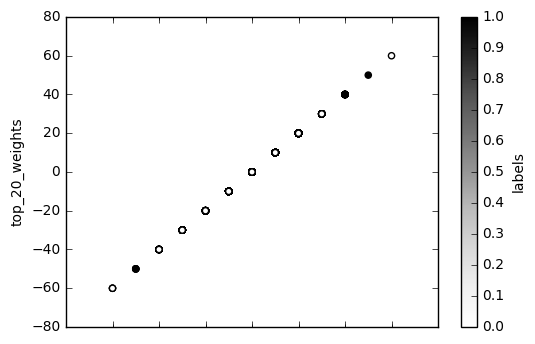

In [138]:
# Kmeans top 20 weights
print "Positive and negative terms with Latent Semantic Analysis"
print "<================================================================>"
km_labels = km_fitter(weights.drop(['all_weights'], axis = 1))
ac_labels = ac_fitter(weights.drop(['all_weights'], axis = 1))
print "Agglomerative Clustering"
ac_pred = printer(ac_labels)
print "<================================================================>"
print "KMeans Clustering"
km_pred = printer(km_labels)


km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=30)
km.fit(weights.drop(['all_weights'], axis = 1))
labels = pd.DataFrame(km.labels_)

le = LabelEncoder()
y = le.fit_transform(posneg_df['airline_sentiment'])

labels2 = labels.copy()
y_pred1 = np.choose(labels, [1,0])
a = classification_report(y, y_pred1).split('total')[1].split('      ')[3]

y_pred2 = np.choose(labels2, [0,1])
b = classification_report(y, y_pred2).split('total')[1].split('      ')[3]
if a >= b:
    y_pred = y_pred1
else:
    y_pred = y_pred2

plot_df = pd.DataFrame()
plot_df['top_20_weights'] = posneg_df['top_20_weights']      
plot_df['labels'] = y_pred
plot_df.plot(kind = 'scatter', x = 'top_20_weights', y = 0, c = 'labels')
plt.show()
    

Agglomerative Clustering
             precision    recall  f1-score   support

          0       0.93      0.60      0.73      3069
          1       0.64      0.94      0.76      2363

avg / total       0.80      0.75      0.74      5432

[[1845 1224]
 [ 144 2219]]
Homogeneity Score: 0.258597105012
Rand: 0.245291407107
<================================================================>
KMeans Clustering
             precision    recall  f1-score   support

          0       0.93      0.60      0.73      3069
          1       0.64      0.94      0.76      2363

avg / total       0.80      0.75      0.74      5432

[[1845 1224]
 [ 144 2219]]
Homogeneity Score: 0.258597105012
Rand: 0.245291407107


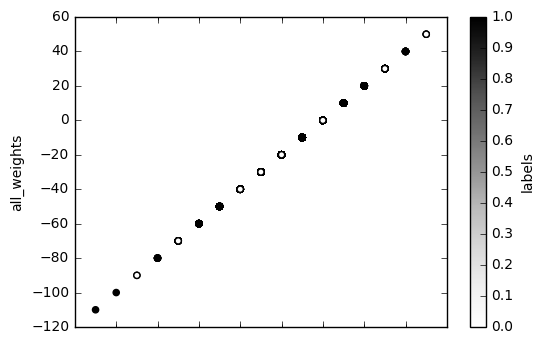

In [139]:
# Kmeans all weights
km_labels = km_fitter(weights.drop(['top_20_weights'], axis = 1))
ac_labels = ac_fitter(weights.drop(['top_20_weights'], axis = 1))
print "Agglomerative Clustering"
ac_pred = printer(ac_labels)
print "<================================================================>"
print "KMeans Clustering"
km_pred = printer(km_labels)

km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=30)
km.fit(weights.drop(['top_20_weights'], axis = 1))
labels = pd.DataFrame(km.labels_)

le = LabelEncoder()
y = le.fit_transform(posneg_df['airline_sentiment'])

labels2 = labels.copy()
y_pred1 = np.choose(labels, [1,0])
a = classification_report(y, y_pred1).split('total')[1].split('      ')[3]

y_pred2 = np.choose(labels2, [0,1])
b = classification_report(y, y_pred2).split('total')[1].split('      ')[3]
if a >= b:
    y_pred = y_pred1
else:
    y_pred = y_pred2

plot_df = pd.DataFrame()
plot_df['all_weights'] = posneg_df['all_weights']      
plot_df['labels'] = y_pred
plot_df.plot(kind = 'scatter', x = 'all_weights', y =0, c = 'labels')
plt.show()

In [117]:
# normalized (LSA: 45)
# LSA + weights: 81
# normalized (weights): 71
# normalized (LSA + weights): 85
# both weights AC: 71
# both weights KM: 81
# Just top_20 KM: 79
# Just all_weights KM: 74

# TO DO:
# To improve score: 
# FIX cluster plots
# Get top 40, stemming (I think this makes the words all unique), textblob sentiment feature
# Try different n-grams, document frequency
# Semantic orienatation?


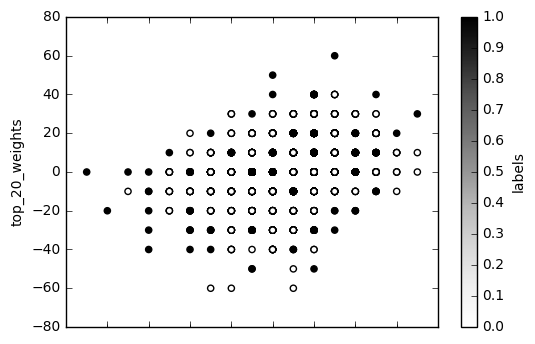

In [140]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=30)
km.fit(weights_copy)
labels = pd.DataFrame(km.labels_)

le = LabelEncoder()
y = le.fit_transform(posneg_df['airline_sentiment'])

labels2 = labels.copy()
y_pred1 = np.choose(labels, [1,0])
a = classification_report(y, y_pred1).split('total')[1].split('      ')[3]

y_pred2 = np.choose(labels2, [0,1])
b = classification_report(y, y_pred2).split('total')[1].split('      ')[3]
if a >= b:
    y_pred = y_pred1
else:
    y_pred = y_pred2

plot_df = pd.DataFrame()
plot_df['all_weights'] = posneg_df['all_weights']
plot_df['top_20_weights'] = posneg_df['top_20_weights']      
plot_df['labels'] = y_pred
plot_df.plot(kind = 'scatter', x = 'all_weights', y ='top_20_weights', c = 'labels')